In [14]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
from sklearn import metrics
plt.rcParams['font.family']     = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
import numpy as np 
# set the style of the axes and the text color
#plt.rcParams["axes.labelweight"] = "bold"
#plt.rcParams["font.weight"] = "bold"
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=1.5
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'
csfont = {'fontname':'Arial','fontsize':25}
tickfont = {'fontname':'Arial','fontsize':16}
files = pd.Series(os.listdir())
files = files[files.str.contains('simruns.csv')]
files[files.str.contains('George-MC-sim-svaddadi-0-100000-.1-1-LHS')].values

array(['George-MC-sim-svaddadi-0-100000-.1-1-LHS-Coeff-TPM-smallest-StandardScaler-simruns.csv'],
      dtype=object)

In [15]:
excelsheet = pd.ExcelFile('/anvil/projects/x-cis220051/corporate/molecular-stethoscope/Teams/Team-2/ClusterMarkers_1819ADcohort-Copy1.congregated_DR.xlsx')
# Get Sheets
Phenotype = excelsheet.parse(excelsheet.sheet_names[0])
TPMs = excelsheet.parse(excelsheet.sheet_names[-1])
TPMs = TPMs[~TPMs.Coeff.isna()]
Coeff = TPMs['Coeff'].values

Phenotype = Phenotype.dropna()
Phenotype = Phenotype.set_index('Isolate ID')

### CSV File containing 965 gene dataset for AD classifier
myDF = pd.read_csv('../data/AD_sort_by_AD_over_NCI_v3_pop.csv')

myDF = myDF.set_index('Unnamed: 0')
myDF = myDF.sort_index()

genes = TPMs.gene_id.str.split('.',expand=True)
genes = genes.iloc[:,0]
TPMs['gene_id'] = genes
TPMs = TPMs.set_index('gene_id')
TPMs = TPMs.sort_index()
TPMs = TPMs.loc[myDF.index.tolist(),:]
tmp = TPMs.reset_index()
myDF = myDF.reset_index()
tmp = tmp.drop(['gene_id','Description', 'ORI', 'MIN', 'MAX', 'AVG', 'Coeff'],axis = 1)
tmp = tmp.dropna(axis = 1)

In [16]:
df1 = pd.read_csv('George-MC-sim-svaddadi-0-100000-.5-1-LHS-Coeff-TPM-smallest-AD-StandardScaler-scores.csv',index_col=0)
df2 = pd.read_csv('George-MC-sim-svaddadi-0-100000-.5-1-LHS-Coeff-TPM-smallest-NCI-StandardScaler-scores.csv',index_col=0)

df = pd.concat((df1,df2)).reset_index(drop=True)
dfT = df.T
for i in dfT.columns.tolist():
    dfT[i] = dfT[i]*TPMs.Coeff.values

scores = np.exp(dfT.sum())/(1+np.exp(dfT.sum()))
preds = [1] * 100000 + [0] * 100000

results = dict()
results['LR'] = scores
results['Pred'] = preds
results = pd.DataFrame(results)
results = results.sort_values('LR').reset_index(drop=True)

(-0.1, 1.1)

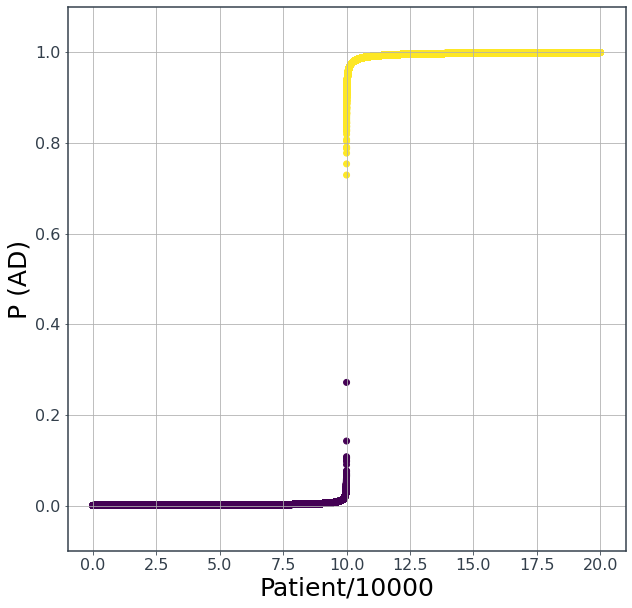

In [17]:
fig,ax = plt.subplots(figsize=(10,10))
plt.scatter(results.index/10000,results.LR,c=results.Pred)

plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.grid()
plt.xlabel('Patient/10000',**csfont)
plt.ylabel('P (AD)',**csfont)
#plt.xlim([0,350])
plt.ylim([-.1,1.1])

(-0.1, 1.1)

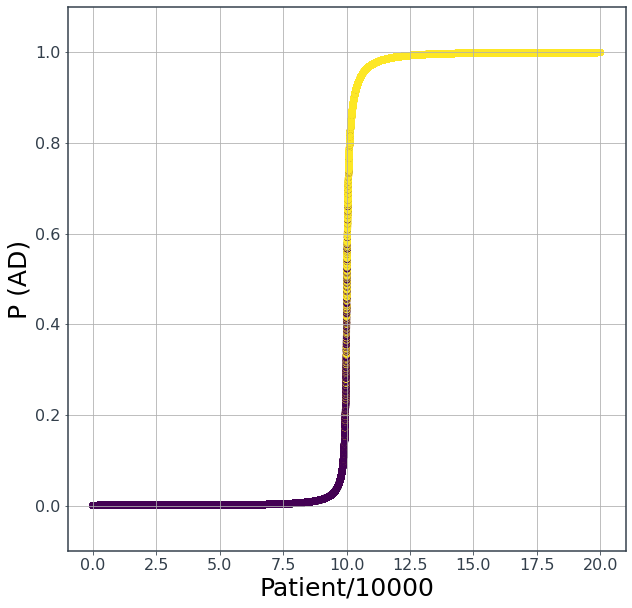

In [18]:
df1 = pd.read_csv('George-MC-sim-svaddadi-0-100000-.5-1-normal-Coeff-TPM-smallest-AD-StandardScaler-scores.csv',index_col=0)
df2 = pd.read_csv('George-MC-sim-svaddadi-0-100000-.5-1-normal-Coeff-TPM-smallest-NCI-StandardScaler-scores.csv',index_col=0)

df = pd.concat((df1,df2)).reset_index(drop=True)
dfT = df.T
for i in dfT.columns.tolist():
    dfT[i] = dfT[i]*TPMs.Coeff.values

scores = np.exp(dfT.sum())/(1+np.exp(dfT.sum()))
preds = [1] * 100000 + [0] * 100000

results = dict()
results['LR'] = scores
results['Pred'] = preds
results = pd.DataFrame(results)
results = results.sort_values('LR').reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
plt.scatter(results.index/10000,results.LR,c=results.Pred)

plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.grid()
plt.xlabel('Patient/10000',**csfont)
plt.ylabel('P (AD)',**csfont)
#plt.xlim([0,350])
plt.ylim([-.1,1.1])

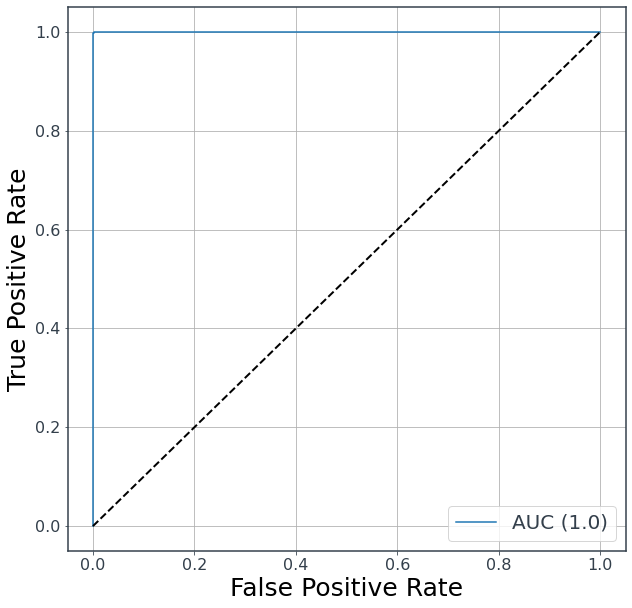

In [21]:
fig,ax = plt.subplots(figsize=(10,10))
fpr, tpr, _ = metrics.roc_curve(results.Pred, results.LR)
auc = metrics.roc_auc_score(results.Pred, results.LR)
#create ROC curves
plt.plot(fpr,tpr,label="AUC ("+str(np.round(auc,2))+ ')')
plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.ylabel('True Positive Rate',**csfont)
plt.xlabel('False Positive Rate',**csfont)
plt.grid()
plt.plot([0,1],[0,1],'--k',linewidth = 2)
plt.legend(loc=4,fontsize = 20)
plt.show()

## Cut-offs

In [31]:
def GetFN(results,cutoff):
    results['cutoff'] = np.where(results.LR <= cutoff,0,1)
    results['diffr'] = results.Pred-results.cutoff
    TP = len(results[(results.diffr == 0) & (results.Pred == 1)])
    TN = len(results[(results.diffr == 0) & (results.Pred == 0)])
    FP = len(results[results.diffr == -1])
    FN = len(results[results.diffr == -1])
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    
    return [FN,Precision,Recall]

FNs = [GetFN(results,c) for c in np.arange(.1,.9,.05)]
FNs = pd.DataFrame(np.array(FNs),columns = ['FN','Precision','Recall'])
FNs['cutoff'] = np.arange(.1,.9,.05)
FNs

,FN,Precision,Recall,cutoff
0,1293.0,0.987234,0.987234,0.10
1,743.0,0.992624,0.992624,0.15
2,512.0,0.994905,0.994905,0.20
3,340.0,0.996610,0.996610,0.25
4,248.0,0.997524,0.997524,0.30
5,190.0,0.998102,0.998102,0.35
6,140.0,0.998600,0.998600,0.40
7,99.0,0.999009,0.999009,0.45
8,76.0,0.999239,0.999239,0.50
9,62.0,0.999379,0.999379,0.55


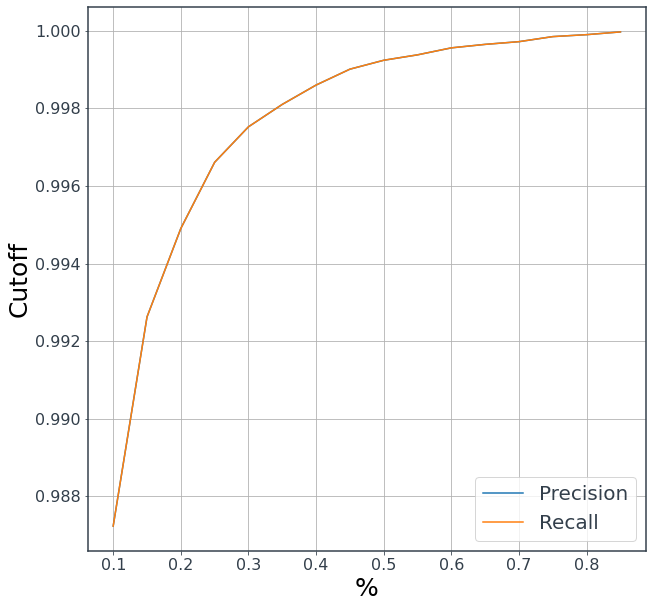

In [33]:
fig,ax = plt.subplots(figsize=(10,10))
plt.plot(FNs.cutoff,FNs.Precision,label="Precision")
plt.plot(FNs.cutoff,FNs.Recall,label="Recall")
plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.ylabel('Cutoff',**csfont)
plt.xlabel('%',**csfont)
plt.grid()
plt.legend(loc=4,fontsize = 20)
plt.show()

## Filtering Effects

In [41]:
TPMs['beta*TPM'] = TPMs.Coeff * TPMs.AVG
TPMs = TPMs.dropna(axis = 1)
TPMs['beta*TPM'].nsmallest(200).reset_index().index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

(-0.1, 1.1)

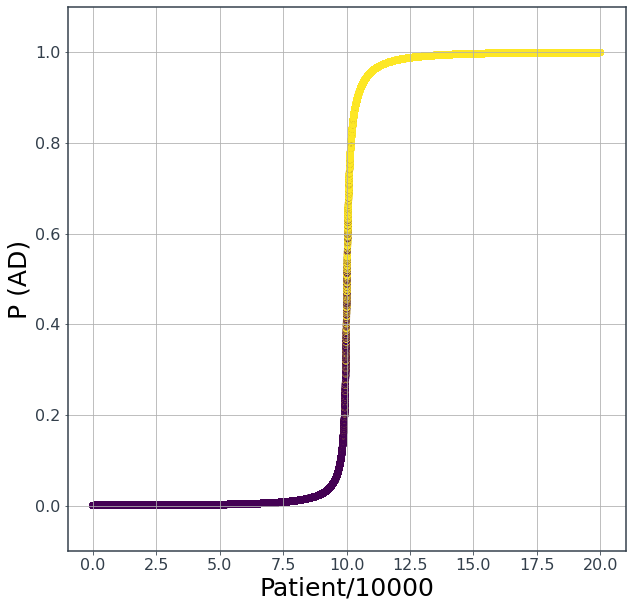

In [51]:
df1 = pd.read_csv('George-MC-sim-svaddadi-0-100000-.5-1-normal-Coeff-TPM-smallest-AD-StandardScaler-scores.csv',index_col=0)
df2 = pd.read_csv('George-MC-sim-svaddadi-0-100000-.5-1-normal-Coeff-TPM-smallest-NCI-StandardScaler-scores.csv',index_col=0)

df = pd.concat((df1,df2)).reset_index(drop=True)
dfT = df.T
for i in dfT.columns.tolist():
    dfT[i] = dfT[i]*TPMs.Coeff.values

dfT = dfT.iloc[100:,:]    
scores = np.exp(dfT.sum())/(1+np.exp(dfT.sum()))
preds = [1] * 100000 + [0] * 100000

results = dict()
results['LR'] = scores
results['Pred'] = preds
results = pd.DataFrame(results)
results = results.sort_values('LR').reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
plt.scatter(results.index/10000,results.LR,c=results.Pred)

plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.grid()
plt.xlabel('Patient/10000',**csfont)
plt.ylabel('P (AD)',**csfont)
#plt.xlim([0,350])
plt.ylim([-.1,1.1])

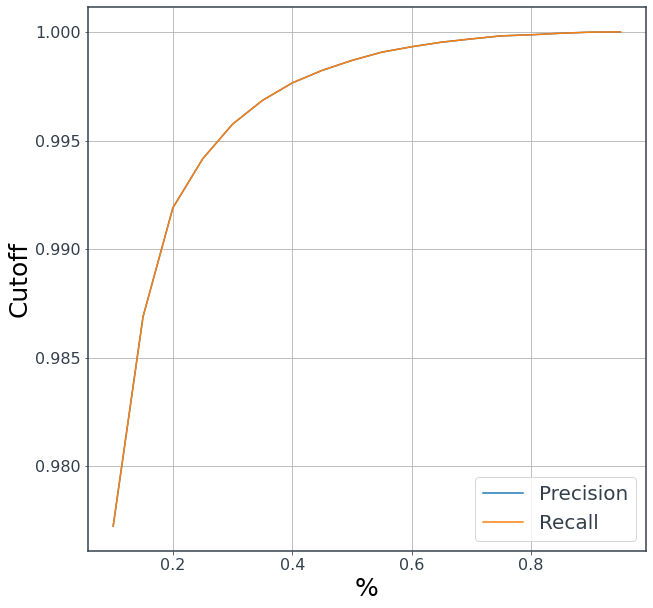

In [52]:
def GetFN(results,cutoff):
    results['cutoff'] = np.where(results.LR <= cutoff,0,1)
    results['diffr'] = results.Pred-results.cutoff
    TP = len(results[(results.diffr == 0) & (results.Pred == 1)])
    TN = len(results[(results.diffr == 0) & (results.Pred == 0)])
    FP = len(results[results.diffr == -1])
    FN = len(results[results.diffr == -1])
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    
    return [FN,Precision,Recall]

FNs = [GetFN(results,c) for c in np.arange(.1,1,.05)]
FNs = pd.DataFrame(np.array(FNs),columns = ['FN','Precision','Recall'])
FNs['cutoff'] = np.arange(.1,1,.05)

fig,ax = plt.subplots(figsize=(10,10))
plt.plot(FNs.cutoff,FNs.Precision,label="Precision")
plt.plot(FNs.cutoff,FNs.Recall,label="Recall")
plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.ylabel('Cutoff',**csfont)
plt.xlabel('%',**csfont)
plt.grid()
plt.legend(loc=4,fontsize = 20)
plt.show()

## Training Testing 

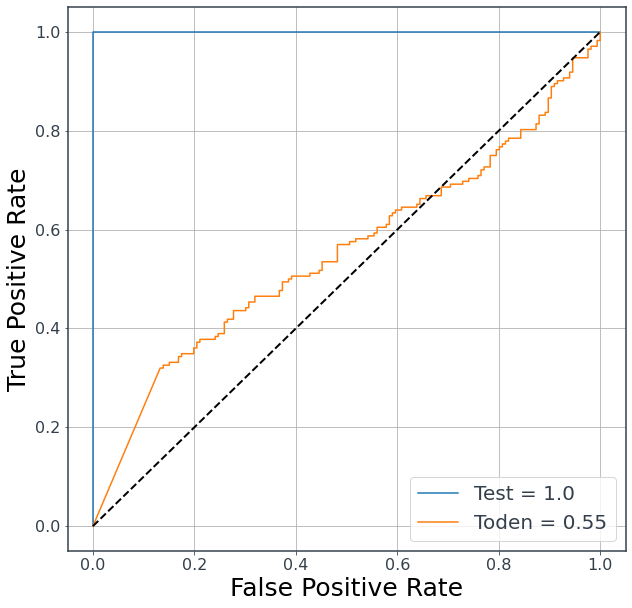

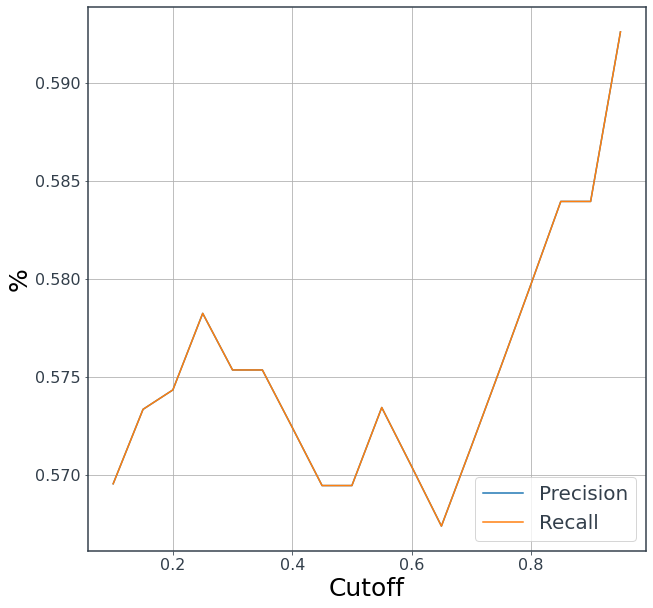

(-0.1, 1.1)

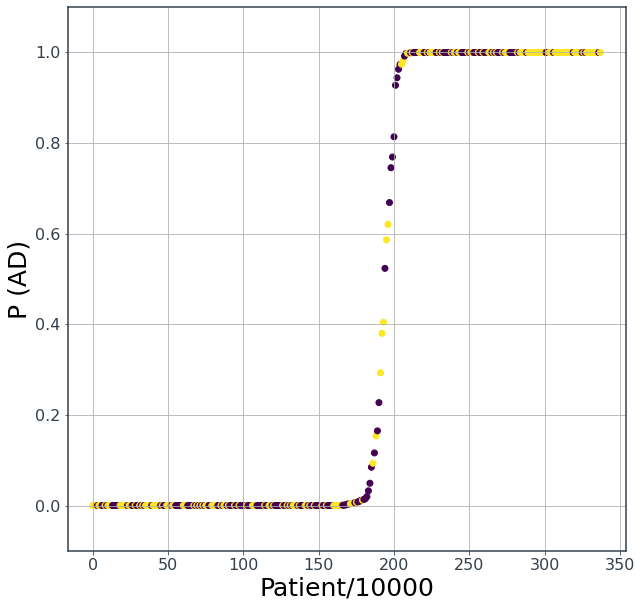

In [92]:
df1 = pd.read_csv('George-MC-sim-svaddadi-0-100000-.5-1-normal-Coeff-TPM-smallest-AD-StandardScaler-scores.csv',index_col=0)
df2 = pd.read_csv('George-MC-sim-svaddadi-0-100000-.5-1-normal-Coeff-TPM-smallest-NCI-StandardScaler-scores.csv',index_col=0)

df = pd.concat((df1,df2)).reset_index(drop=True)
dfT = df.T
for i in dfT.columns.tolist():
    dfT[i] = dfT[i]*TPMs.Coeff.values

dfT = dfT.iloc[100:,:]    
scores = np.exp(dfT.sum())/(1+np.exp(dfT.sum()))
preds = [1] * 100000 + [0] * 100000

df['Label'] = preds
df = df.sample(frac=1).reset_index(drop=True)
fig,ax = plt.subplots(figsize=(10,10))
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X,y = df.iloc[:,:-1].values, df.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#create ROC curves
y_pred = clf.predict_proba(X_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)
auc = metrics.roc_auc_score(y_test,y_pred)

plt.plot(fpr,tpr,label="Test = "+ str(np.round(auc,2)))

y_pred = clf.predict_proba(StandardScaler().fit_transform(tmp.T))[:,1]
results = dict()
results['LR'] = y_pred
results['Patient'] = tmp.columns.tolist()
results = pd.DataFrame(results)
pat = results.Patient.str.split('-',expand=True)
results['patno'] = pat.iloc[:,0].astype(float)

def getlabel(patno):
    t = Phenotype.loc[patno,'Disease']
    
    if t == 'AD':
        return 1
    else:
        return 0

results['Pred'] = results.patno.apply(getlabel)

fpr, tpr, _ = metrics.roc_curve(results.Pred.values,y_pred)
auc = metrics.roc_auc_score(results.Pred.values,y_pred)

plt.plot(fpr,tpr,label="Toden = "+ str(np.round(auc,2)))



#create ROC curves
plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.ylabel('True Positive Rate',**csfont)
plt.xlabel('False Positive Rate',**csfont)
plt.grid()
plt.plot([0,1],[0,1],'--k',linewidth = 2)
plt.legend(loc=4,fontsize = 20)
plt.show()



def GetFN(results,cutoff):
    results['cutoff'] = np.where(results.LR <= cutoff,0,1)
    results['diffr'] = results.Pred-results.cutoff
    TP = len(results[(results.diffr == 0) & (results.Pred == 1)])
    TN = len(results[(results.diffr == 0) & (results.Pred == 0)])
    FP = len(results[results.diffr == -1])
    FN = len(results[results.diffr == -1])
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    
    return [FN,Precision,Recall]

FNs = [GetFN(results,c) for c in np.arange(.1,1,.05)]
FNs = pd.DataFrame(np.array(FNs),columns = ['FN','Precision','Recall'])
FNs['cutoff'] = np.arange(.1,1,.05)

fig,ax = plt.subplots(figsize=(10,10))
plt.plot(FNs.cutoff,FNs.Precision,label="Precision")
plt.plot(FNs.cutoff,FNs.Recall,label="Recall")
plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.xlabel('Cutoff',**csfont)
plt.ylabel('%',**csfont)
plt.grid()
plt.legend(loc=4,fontsize = 20)
plt.show()

fig,ax = plt.subplots(figsize=(10,10))
results = results.sort_values('LR').reset_index(drop=True)
plt.scatter(results.index,results.LR,c=results.Pred)

plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.grid()
plt.xlabel('Patient/10000',**csfont)
plt.ylabel('P (AD)',**csfont)
#plt.xlim([0,350])
plt.ylim([-.1,1.1])

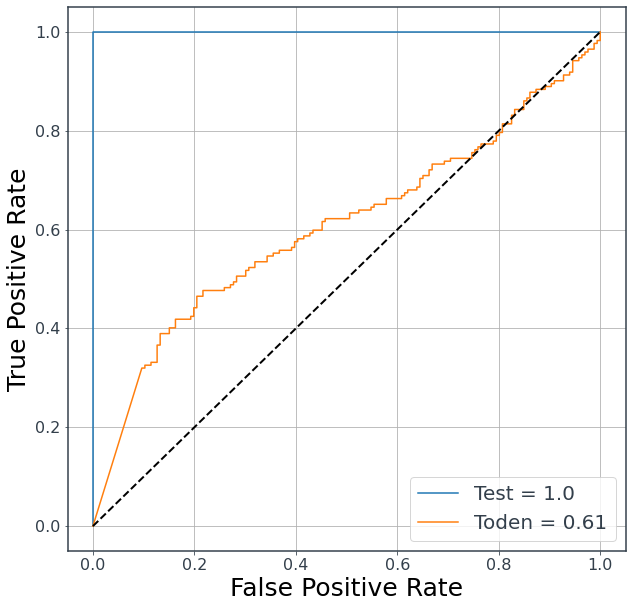

In [93]:
df1 = pd.read_csv('George-MC-sim-svaddadi-0-100000-.1-1-normal-Coeff-TPM-smallest-AD-StandardScaler-scores.csv',index_col=0)
df2 = pd.read_csv('George-MC-sim-svaddadi-0-100000-.1-1-normal-Coeff-TPM-smallest-NCI-StandardScaler-scores.csv',index_col=0)

df = pd.concat((df1,df2)).reset_index(drop=True)
dfT = df.T
for i in dfT.columns.tolist():
    dfT[i] = dfT[i]*TPMs.Coeff.values

dfT = dfT.iloc[100:,:]    
scores = np.exp(dfT.sum())/(1+np.exp(dfT.sum()))
preds = [1] * 100000 + [0] * 100000

df['Label'] = preds
df = df.sample(frac=1).reset_index(drop=True)
fig,ax = plt.subplots(figsize=(10,10))
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X,y = df.iloc[:,:-1].values, df.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#create ROC curves
y_pred = clf.predict_proba(X_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)
auc = metrics.roc_auc_score(y_test,y_pred)

plt.plot(fpr,tpr,label="Test = "+ str(np.round(auc,2)))

y_pred = clf.predict_proba(StandardScaler().fit_transform(tmp.T))[:,1]
results = dict()
results['LR'] = y_pred
results['Patient'] = tmp.columns.tolist()
results = pd.DataFrame(results)
pat = results.Patient.str.split('-',expand=True)
results['patno'] = pat.iloc[:,0].astype(float)

def getlabel(patno):
    t = Phenotype.loc[patno,'Disease']
    
    if t == 'AD':
        return 1
    else:
        return 0

results['Pred'] = results.patno.apply(getlabel)

fpr, tpr, _ = metrics.roc_curve(results.Pred.values,y_pred)
auc = metrics.roc_auc_score(results.Pred.values,y_pred)

plt.plot(fpr,tpr,label="Toden = "+ str(np.round(auc,2)))



#create ROC curves
plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.ylabel('True Positive Rate',**csfont)
plt.xlabel('False Positive Rate',**csfont)
plt.grid()
plt.plot([0,1],[0,1],'--k',linewidth = 2)
plt.legend(loc=4,fontsize = 20)
plt.show()






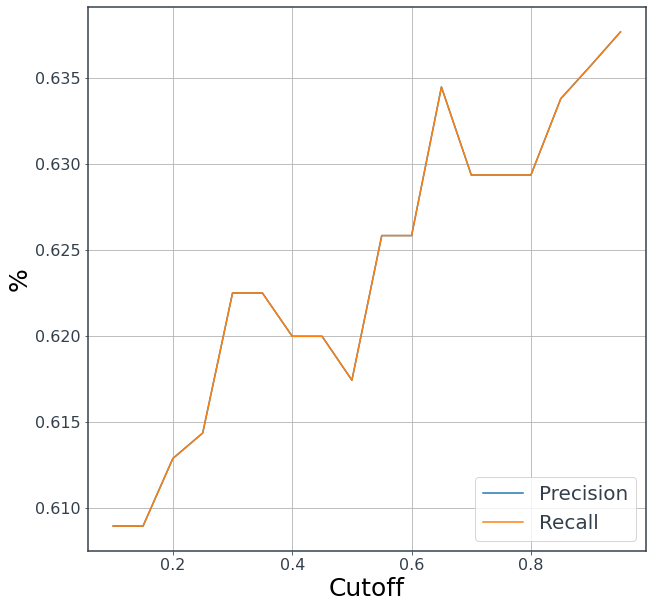

(-0.1, 1.1)

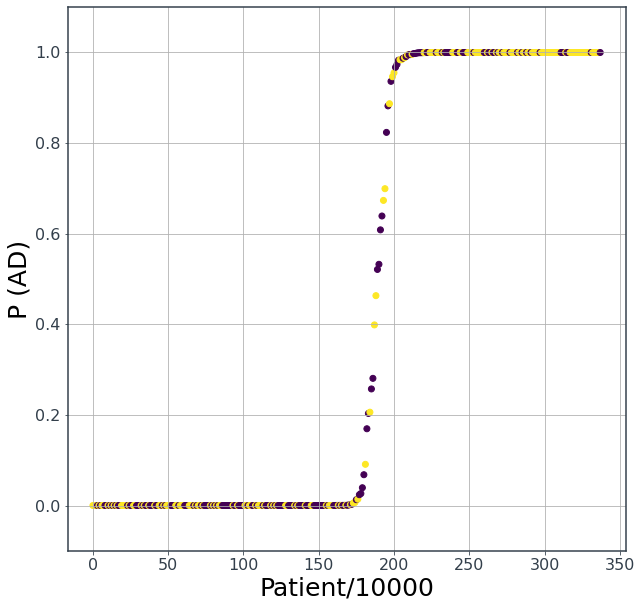

In [94]:
def GetFN(results,cutoff):
    results['cutoff'] = np.where(results.LR <= cutoff,0,1)
    results['diffr'] = results.Pred-results.cutoff
    TP = len(results[(results.diffr == 0) & (results.Pred == 1)])
    TN = len(results[(results.diffr == 0) & (results.Pred == 0)])
    FP = len(results[results.diffr == -1])
    FN = len(results[results.diffr == -1])
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    
    return [FN,Precision,Recall]

FNs = [GetFN(results,c) for c in np.arange(.1,1,.05)]
FNs = pd.DataFrame(np.array(FNs),columns = ['FN','Precision','Recall'])
FNs['cutoff'] = np.arange(.1,1,.05)

fig,ax = plt.subplots(figsize=(10,10))
plt.plot(FNs.cutoff,FNs.Precision,label="Precision")
plt.plot(FNs.cutoff,FNs.Recall,label="Recall")
plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.xlabel('Cutoff',**csfont)
plt.ylabel('%',**csfont)
plt.grid()
plt.legend(loc=4,fontsize = 20)
plt.show()

fig,ax = plt.subplots(figsize=(10,10))
results = results.sort_values('LR').reset_index(drop=True)
plt.scatter(results.index,results.LR,c=results.Pred)

plt.yticks(**tickfont)
plt.xticks(**tickfont)
plt.grid()
plt.xlabel('Patient/10000',**csfont)
plt.ylabel('P (AD)',**csfont)
#plt.xlim([0,350])
plt.ylim([-.1,1.1])